In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import sys
import os
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
from numba import njit
import polars as pl
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from support.imu_calculations import *

In [54]:
_parent_folder = "encoder_validation"
_folder_name = "sk28_err_1"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\CMC\\Documents\\openposelibs\\pose\\armbo\\simulation\\..\\recording_programs\\test_data\\encoder_validation'

In [55]:
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu01.csv"))
_sk_df["rust_time"] = _sk_df["rust_time"].apply(lambda x: datetime.fromtimestamp(x))
# set zero
_sk_df.rename(columns={"rust_time": "time", "e_fr":"e_t"}, inplace=True)

_sk_df = set_zero(_sk_df, column_name = ["e_t", "e_rr", "e_rl"])
# rename columns
_sk_df["e_t"] =  -_sk_df["e_t"]

_sk_df

,sys_time,time,e_t,e_fl,e_rr,e_rl,rtc,mils,sync,ax,ay,az,gx,gy,gz,mx,my,mz
0,2023-03-15 12:26:32.263859,2023-03-15 12:26:32.264318,0,0,0,0,2023-03-15 05.56.31.000000 PM,1095754,0,-9.930369,0.280529,-0.312231,-0.068598,-0.007622,0.022866,151.500000,-261.300018,10.500000
1,2023-03-15 12:26:32.416379,2023-03-15 12:26:32.416509,0,0,0,0,2023-03-15 05.56.31.000000 PM,1095767,0,-9.923790,0.292492,-0.307445,-0.076220,-0.015244,0.015244,161.100006,-256.500000,8.700001
2,2023-03-15 12:26:32.416379,2023-03-15 12:26:32.416832,0,0,0,0,2023-03-15 05.56.31.000000 PM,1095779,0,-9.913023,0.282323,-0.320006,-0.053354,-0.015244,0.022866,158.700012,-258.900024,10.500000
3,2023-03-15 12:26:32.416875,2023-03-15 12:26:32.417097,0,0,0,0,2023-03-15 05.56.31.000000 PM,1095792,0,-9.923192,0.295483,-0.328979,-0.060976,-0.007622,0.015244,153.900009,-263.700012,10.500000
4,2023-03-15 12:26:32.416875,2023-03-15 12:26:32.417360,0,0,0,0,2023-03-15 05.56.31.000000 PM,1095805,0,-9.932164,0.291894,-0.331371,-0.060976,-0.007622,0.022866,156.300003,-258.900024,10.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,2023-03-15 12:27:09.962946,2023-03-15 12:27:09.963319,0,0,-41539,0,2023-03-15 05.57.09.000000 PM,1133453,0,-9.911229,0.289501,-0.330773,-0.053354,0.000000,0.022866,165.900009,-251.700012,7.500000
2988,2023-03-15 12:27:09.975853,2023-03-15 12:27:09.976018,0,0,-41539,0,2023-03-15 05.57.09.000000 PM,1133466,0,-9.911827,0.273949,-0.319408,-0.076220,0.000000,0.030488,156.300003,-254.100006,8.100000
2989,2023-03-15 12:27:09.988280,2023-03-15 12:27:09.988724,0,0,-41539,0,2023-03-15 05.57.09.000000 PM,1133478,0,-9.923192,0.285912,-0.315820,-0.060976,-0.015244,0.022866,153.900009,-251.700012,8.700001
2990,2023-03-15 12:27:10.001322,2023-03-15 12:27:10.001317,0,0,-41539,0,2023-03-15 05.57.09.000000 PM,1133491,0,-9.919603,0.268566,-0.308044,-0.060976,-0.007622,0.022866,156.300003,-249.300003,7.500000


In [56]:
# type in marker details
_xm = get_marker_name(3)
_zm = get_marker_name(1)
_om = get_marker_name(2)

In [57]:
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [58]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)


100%|██████████| 2567/2567 [00:00<00:00, 129388.18it/s]


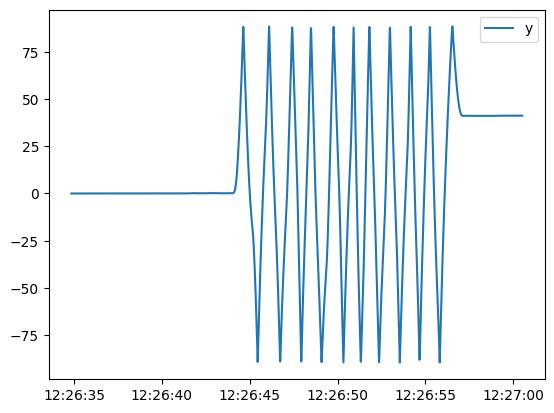

In [59]:
# plt.plot(_m_df["time"][1000:2000], _theta_x[1000:2000], label="x")

plt.plot(_m_df["time"], _theta_y, label="y")
# plt.plot(_m_df["time"][1000:2000], _theta_z[1000:2000], label="z")
# change angle to 0 to 360
plt.legend()
# max(_theta_z)

In [60]:
theta_df = pd.DataFrame({"time": _m_df["time"], "theta_y": _theta_y})
theta_df["diff"] = abs(theta_df["theta_y"].diff())
# replace nan with 0
theta_df["diff"].fillna(0, inplace=True)
# integrate angle
df, _ = get_orientation(theta_df, "diff")


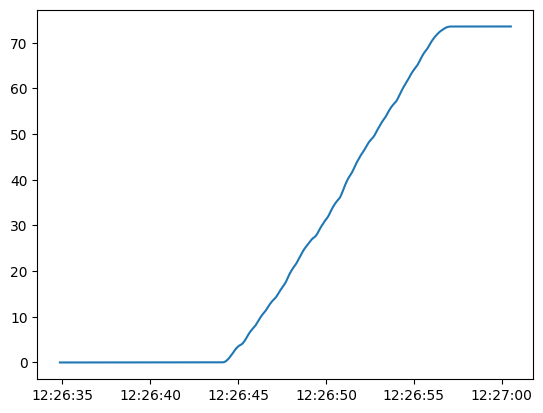

In [61]:
plt.plot(df["time"], df["theta"], label="y")

In [62]:
_ang_df = _sk_df[['time', 'e_rr']].copy()

In [66]:
_ang_df["ang_y"] = -_ang_df["e_rr"].apply(lambda x: x*0.09)

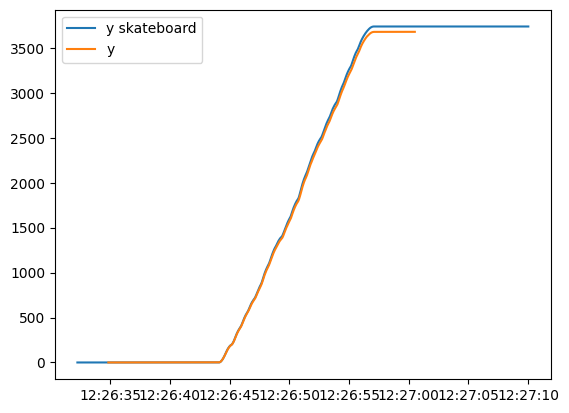

In [67]:
plt.plot(_ang_df["time"], _ang_df["ang_y"], label="y skateboard")
plt.plot(df["time"], df["theta"]*50, label="y")
plt.legend()

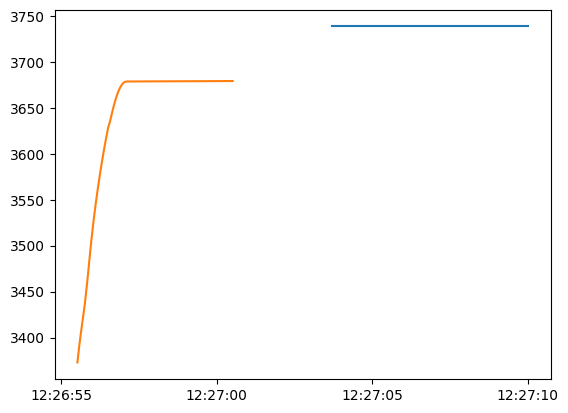

In [68]:
plt.plot(_ang_df["time"][-500:], _ang_df["ang_y"][-500:], label="y skateboard")
plt.plot(df["time"][-500:], df["theta"][-500:]*50, label="y")